In [23]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import transformers

In [24]:
torch.cuda.empty_cache()

## 1. Download imdb dataset from hugging face.

 Return  Dataset objects

In [25]:
dataset = datasets.load_dataset("imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Show the downloaded data

In [26]:
print(dataset["train"][0])


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## 2. Loading the Pre-trained distilBERT model
 -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

In [27]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
transformer = model_class.from_pretrained(pretrained_weights)

In [28]:
tokenizer("hello world!")

{'input_ids': [101, 7592, 2088, 999, 102], 'attention_mask': [1, 1, 1, 1, 1]}

## 3. Preprocess the input data

In [29]:
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

In [30]:
tokenized_datasets = dataset.map(
    tokenize_function, batched=True
)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# To speed up training, we chose a small subset of the data. 
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

# Split train_data into train and validate data.
train_valid_data = small_train_dataset.train_test_split(test_size=0.25)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [31]:
batch_size = 6

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_data_loader = DataLoader(valid_data, batch_size=batch_size)
test_data_loader = DataLoader(small_eval_dataset, batch_size=batch_size)

## 4. Define the modal and training

In [32]:
class MyBert(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids, attention_mask):
        output = self.transformer(ids, attention_mask=attention_mask, output_attentions=True)
        hidden = output.last_hidden_state
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        return prediction
    
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
output_dim = len(train_data["labels"].unique())
freeze = False

model = MyBert(transformer, output_dim, freeze)

In [34]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [35]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["input_ids"].to(device)
        label = batch["labels"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        prediction = model(ids, attention_mask)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [39]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["input_ids"].to(device)
            label = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            prediction = model(ids, attention_mask=attention_mask)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [37]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [40]:
n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_dataloader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 42/42 [00:04<00:00,  8.87it/s]


epoch: 0
train_loss: 0.248, train_acc: 0.904
valid_loss: 0.326, valid_acc: 0.873


evaluating...: 100%|██████████| 42/42 [00:04<00:00,  8.86it/s]


epoch: 1
train_loss: 0.095, train_acc: 0.975
valid_loss: 0.387, valid_acc: 0.849


evaluating...: 100%|██████████| 42/42 [00:04<00:00,  8.83it/s]

epoch: 2
train_loss: 0.052, train_acc: 0.987
valid_loss: 0.471, valid_acc: 0.853


## 5. show the result

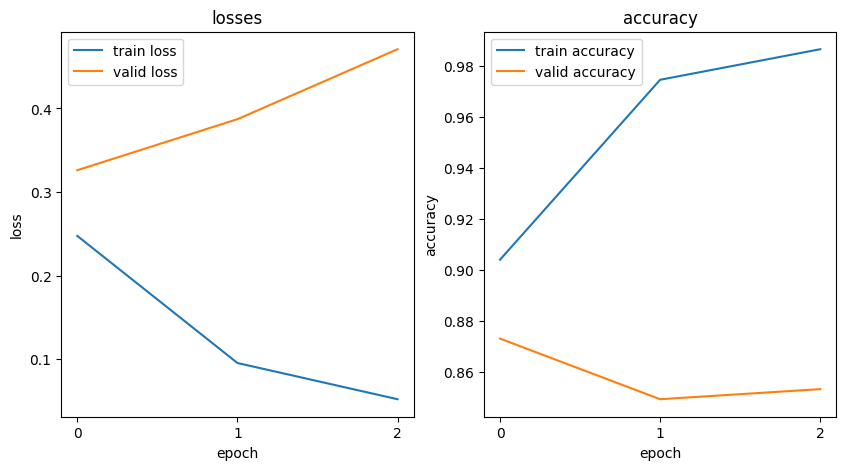

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plt.figure(dpi=1200)
axes[0].plot(metrics["train_losses"], label="train loss")
axes[0].plot(metrics["valid_losses"], label="valid loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].set_xticks(range(n_epochs))
axes[0].set_title("losses")
axes[0].legend()

axes[1].plot(metrics["train_accs"], label="train accuracy")
axes[1].plot(metrics["valid_accs"], label="valid accuracy")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].set_xticks(range(n_epochs))
axes[1].set_title("accuracy")
axes[1].set_title("accuracy")
axes[1].legend()

plt.show()

In [ ]:
model.load_state_dict(torch.load("transformer.pt"))
test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

evaluating...: 100%|██████████| 167/167 [00:18<00:00,  8.87it/s]

test_loss: 0.327, test_acc: 0.862


In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "i liked this movie. it was great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.781315803527832)

In [ ]:
text = "why i loved this movie? i just didn't"

predict_sentiment(text, model, tokenizer, device)

(0, 0.6811992526054382)